In [1]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from copy import deepcopy

## Set the learning algorithm

In [2]:
ALGO = RandomForestRegressor
params = {'random_state': 110, 'max_depth': 5, 'verbose': 1, 'n_jobs': 4}
name = 'RF'

# ALGO = LR
# params = {}
# name = 'LR'

# ALGO = MLPRegressor
# params = {'random_state': 110, 'hidden_layer_sizes': (50, 50), 'early_stopping': True, 'verbose': 1}
# name = 'NN'

## Load Data

In [3]:
org_data = pd.read_pickle(r'data_org.pkl')
p_matched = pd.read_pickle(r'matched_type.pkl')

In [4]:
p_matched

,Unnamed: 0,state_code,conforming_loan_limit,action_taken,purchaser_type,loan_type,lien_status,open-end_line_of_credit,loan_amount,loan_to_value_ratio,...,applicant_age,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units,LV,DI,income_brackets
0,530,CA,NC,1,0,1,1,2,905000.0,36.290,...,35-44,26.17,86300,211,2618,3446,14,0,4,4
1,8799564,CA,NC,1,0,1,1,2,1405000.0,35.900,...,35-44,51.46,129900,209,1991,2163,48,0,4,4
2,548,FL,C,0,0,1,1,2,155000.0,104.375,...,25-34,63.00,66900,109,2117,3084,14,6,7,1
3,2308143,FL,C,1,6,1,1,2,135000.0,102.510,...,25-34,25.33,66900,71,716,1389,39,6,7,1
4,601,AL,C,0,0,4,1,2,75000.0,100.000,...,55-64,7.81,58300,113,1545,2297,25,6,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679765,8395614,MS,C,1,3,1,1,2,305000.0,95.000,...,35-44,16.84,60400,234,1854,1966,17,5,6,2
679766,9060784,PA,C,1,1,1,1,2,115000.0,84.838,...,25-34,93.46,62800,72,1201,2839,70,4,5,1
679767,1869941,PA,C,1,1,1,1,2,65000.0,85.000,...,25-34,3.67,63200,104,1318,1699,67,4,5,1
679768,9060795,FL,C,1,1,1,1,2,175000.0,97.000,...,55-64,75.49,75400,66,926,1711,40,5,6,0


## Handling missing values

In [5]:
org_data['income'].fillna(71, inplace=True)
org_data['loan_to_value_ratio'].fillna(93, inplace=True)
org_data['debt_to_income_ratio'].fillna(41, inplace=True)
p_matched['income'].fillna(56, inplace=True)
p_matched['loan_to_value_ratio'].fillna(93, inplace=True)
p_matched['debt_to_income_ratio'].fillna(44, inplace=True)

## Dropping Rows with Missing Values

In [6]:
p_matched = p_matched[['Unnamed: 0', 'interest_rate','applicant_sex','income','applicant_race', 'state_code', 'loan_type',
                                   'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]
matched_b = p_matched.iloc[0::2, :]
matched_w = p_matched.iloc[1::2, :]
drop_index = list(set(np.where(pd.isna(matched_w).sum(axis=1).values>0)[0]) | set(np.where(pd.isna(matched_b).sum(axis=1).values>0)[0]))
matched_w = matched_w.drop(index=matched_w.index[drop_index])
matched_b = matched_b.drop(index=matched_b.index[drop_index])
p_matched = pd.concat((matched_w, matched_b))

In [7]:
org_data = org_data[['interest_rate','applicant_sex','income','applicant_race', 'state_code', 'loan_type',
                                   'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]
org_data.dropna(inplace=True)

## Train-Test Split

In [8]:
ratio = 0.25
n_w = p_matched.shape[0]//2
n_test = int(ratio*n_w)
index = np.random.permutation(n_w)
test_ind = index[:n_test]
train_ind = index[n_test:]

match_test_w = p_matched.iloc[test_ind, :]
match_test_b = p_matched.iloc[test_ind+n_w, :]
match_train_w = p_matched.iloc[train_ind, :]
match_train_b = p_matched.iloc[train_ind+n_w, :]
match_test = pd.concat((match_test_w, match_test_b))
match_train = pd.concat((match_train_w, match_train_b))
test_ids = set(match_test['Unnamed: 0'].values)
org_data = org_data[~org_data.index.isin(test_ids)]

## Prepare the Original Data

In [9]:
X_lr = org_data[['applicant_race', 'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]
X_lr['log_income'] = np.log(org_data['income'])
sex = pd.get_dummies(org_data['applicant_sex'], drop_first=True, prefix='sex')
X_lr[sex.columns] = sex
state = pd.get_dummies(org_data['state_code'], drop_first=True, prefix='state')
X_lr[state.columns] = state
ltype = pd.get_dummies(org_data['loan_type'], drop_first=True, prefix='type')
X_lr[ltype.columns] = ltype
y_lr = org_data['interest_rate'].clip(0, 12)

<ipython-input-9-90b60653d91a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_lr['log_income'] = np.log(org_data['income'])
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Algorithm 1: Use all features and train a Regression algorithm on *Original data*

In [10]:
reg1 = ALGO(**params).fit(X_lr, y_lr)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.1min finished


### Algorithm 2: Don't use *Race* and train another Linear Regression on *Original data*

In [ ]:
X_lr2 = deepcopy(X_lr)
X_lr2['applicant_race']=0

In [ ]:
reg2 = ALGO(**params).fit(X_lr2,y_lr)

### Algorithm 3: Don't use *Race* and train another Linear Regression on *Matched Data*

In [11]:
# Training data
X_lr_matched = match_train[['applicant_race', 'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]
X_lr_matched['log_income'] = np.log(p_matched['income'])
sex = pd.get_dummies(match_train['applicant_sex'], drop_first=True, prefix='sex')
X_lr_matched[sex.columns] = sex
state = pd.get_dummies(match_train['state_code'], drop_first=True, prefix='state')
X_lr_matched[state.columns] = state
ltype = pd.get_dummies(match_train['loan_type'], drop_first=True, prefix='type')
X_lr_matched[ltype.columns] = ltype
y_lr_matched = match_train['interest_rate'].clip(0, 12)

<ipython-input-11-d8b3d709c4c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_lr_matched['log_income'] = np.log(p_matched['income'])
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [12]:
# Test data
X_test = match_test[['applicant_race', 'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]
X_test['log_income'] = np.log(match_test['income'])
sex = pd.get_dummies(match_test['applicant_sex'], drop_first=True, prefix='sex')
X_test[sex.columns] = sex
state = pd.get_dummies(match_test['state_code'], drop_first=True, prefix='state')
X_test[state.columns] = state
ltype = pd.get_dummies(match_test['loan_type'], drop_first=True, prefix='type')
X_test[ltype.columns] = ltype
y_test = match_test['interest_rate'].clip(0, 12)

<ipython-input-12-c243a87e3802>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['log_income'] = np.log(match_test['income'])


In [15]:
X_lr3 = deepcopy(X_lr_matched)
X_lr3['applicant_race']=0

In [ ]:
reg3 = ALGO(**params).fit(X_lr3, y_lr_matched)

### Algorithm 4: randomly swap the labels

In [13]:
n_w_train = y_lr_matched.shape[0]//2
swaps_w = (np.random.uniform(0, 1, n_w_train) > 0.5).astype(int)
swaps_b = 1 - swaps_w
y_lr_matched = y_lr_matched.values
y_w = y_lr_matched[:n_w_train]*swaps_w + y_lr_matched[n_w_train:]*swaps_b
y_b = y_lr_matched[:n_w_train]*swaps_b + y_lr_matched[n_w_train:]*swaps_w
y_swap = np.concatenate((y_w, y_b))

In [16]:
reg4 = ALGO(**params).fit(X_lr3, y_swap)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   12.1s finished


## Predicting Interest Rate using algorithms 1,2,3 

In [17]:
n_w_test = X_test.shape[0]//2

In [18]:
pred1 = reg1.predict(X_test).clip(0, 12)
pred2 = reg2.predict(X_test).clip(0, 12)
pred3 = reg3.predict(X_test).clip(0, 12)
pred4 = reg4.predict(X_test).clip(0, 12)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


## Evaluating Accuracy

In [19]:
# Overall accuracy
print(f"Algorithm 1 Test RMSE: {mean_squared_error(y_test, pred1):.3f}")
print(f"Algorithm 2 Test RMSE: {mean_squared_error(y_test, pred2):.3f}")
print(f"Algorithm 3 Test RMSE: {mean_squared_error(y_test, pred3):.3f}")
print(f"Algorithm 4 Test RMSE: {mean_squared_error(y_test, pred4):.3f}")

Algorithm 4 Test RMSE: 0.758


In [20]:
# Accuracy among whites
print(f"Algorithm 1 Test RMSE: {mean_squared_error(y_test[:n_w_test], pred1[:n_w_test]):.3f}")
print(f"Algorithm 2 Test RMSE: {mean_squared_error(y_test[:n_w_test], pred2[:n_w_test]):.3f}")
print(f"Algorithm 3 Test RMSE: {mean_squared_error(y_test[:n_w_test], pred3[:n_w_test]):.3f}")
print(f"Algorithm 4 Test RMSE: {mean_squared_error(y_test[:n_w_test], pred4[:n_w_test]):.3f}")

Algorithm 4 Test RMSE: 0.681


In [21]:
# Accuracy among blacks
print(f"Algorithm 1 Test RMSE: {mean_squared_error(y_test[n_w_test:], pred1[n_w_test:]):.3f}")
print(f"Algorithm 2 Test RMSE: {mean_squared_error(y_test[n_w_test:], pred2[n_w_test:]):.3f}")
print(f"Algorithm 3 Test RMSE: {mean_squared_error(y_test[n_w_test:], pred3[n_w_test:]):.3f}")
print(f"Algorithm 4 Test RMSE: {mean_squared_error(y_test[n_w_test:], pred4[n_w_test:]):.3f}")

Algorithm 4 Test RMSE: 0.835


## Evaluating Fairness

### Histogram of Interest Rate for algorithm 1

In [ ]:
plt.hist(pred1[:n_w_test],bins=50, density=True)
plt.hist(pred1[n_w_test:],bins=50,alpha=0.5, density=True)
diff = (abs(pred1[:n_w_test]-pred1[n_w_test:])).mean()
plt.legend(['White', 'Black'])
plt.xlabel('Predicted Interest Rate')
plt.title(f'CFU: {diff:.4f}')
plt.tight_layout()
plt.savefig(f'Interest_Rate_{name}1.pdf')

### Histogram of Interest Rate for algorithm 2

In [ ]:
plt.hist(pred2[:n_w_test],bins=50, density=True)
plt.hist(pred2[n_w_test:],bins=50,alpha=0.5, density=True)
diff = (abs(pred2[:n_w_test]-pred2[n_w_test:])).mean()
plt.legend(['White', 'Black'])
plt.xlabel('Predicted Interest Rate')
plt.title(f'CFU: {diff:.4f}')
plt.tight_layout()
plt.savefig(f'Interest_Rate_{name}2.pdf')

### Histogram of Interest Rate for algorithm 3

In [ ]:
plt.hist(pred3[:n_w_test],bins=50, density=True)
plt.hist(pred3[n_w_test:],bins=50,alpha=0.5, density=True)
diff = (abs(pred3[:n_w_test]-pred3[n_w_test:])).mean()
plt.legend(['White', 'Black'])
plt.xlabel('Predicted Interest Rate')
plt.title(f'CFU: {diff:.4f}')
plt.tight_layout()
plt.savefig(f'Interest_Rate_{name}3.pdf')

### Histogram of Interest Rate for algorithm 4

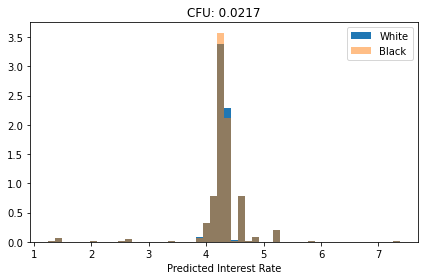

In [22]:
plt.hist(pred4[:n_w_test],bins=50, density=True)
plt.hist(pred4[n_w_test:],bins=50,alpha=0.5, density=True)
diff = (abs(pred4[:n_w_test]-pred4[n_w_test:])).mean()
plt.legend(['White', 'Black'])
plt.xlabel('Predicted Interest Rate')
plt.title(f'CFU: {diff:.4f}')
plt.tight_layout()
plt.savefig(f'Interest_Rate_{name}4.pdf')